In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

D:\Miniconda3\envs\ml\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [145]:
class NeuralNet:
    def __init__(self, layers):
        self.layers = layers
        self.n_in, self.n_out = layers[0].n_in, layers[-1].n_out
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, delta):
        for layer in self.layers[::-1]:
            delta = layer.backward(delta)
        return delta
    
    def gradient_descent(self, alpha, lr):
        for layer in self.layers:
            layer.gradient_descent(alpha, lr)
            
    def reset_velocity(self):
        for layer in self.layers:
            layer.reset_velocity()
    
class MeanSquareLoss:
    def __init__(self):
        pass
    
    def forward(self, ypred, ytrue):
        d = ypred-ytrue
        n = len(d)
        self.diff_cache = d
        return 0.5 * np.sum(d*d) / n
    
    def backward(self):
        '''delta: (B, N_neuron)'''
        return self.diff_cache / n

class CrossEntropyLossFromLogits:
    def __init__(self):
        pass
    
    def forward(self, ypred, ytrue):
        n = ypred.shape[0]
        ex = np.exp(ypred-np.max(ypred))
        sum_ex = np.sum(ex, axis=1).reshape((-1,1))
        act = ex / sum_ex
        
        log_act = -np.log(act[range(n), ytrue])
        
        self.cache = (act.copy(), ytrue)
        return np.sum(log_act) / n
    
    def backward(self):
        '''delta: (B, N_neuron)'''
        act, ytrue = self.cache
        n = act.shape[0]
        act[range(n), ytrue] -= 1
        return act / n

    
class LinearLayer:
    def __init__(self, n_in, n_out, activation_func="identity"):
        self.n_in, self.n_out = n_in, n_out
        self.activation_func = activation_func
        self.W = np.random.randn(n_out, n_in) / n_in
        self.b = np.random.randn(n_out, 1) * 0.0
    
    def forward(self, x):
        net = np.matmul( x, self.W.T ) + self.b.T
        if self.activation_func == "sigmoid":
            act = 1. / (1. + np.exp(-net))
        else: # identity
            act = net
        self.cache = (net, act, x)
#         print("forward", net.shape, act.shape, x.shape)
        return act
    
    def backward(self, delta):
        net, act, x = self.cache
        if self.activation_func == "sigmoid":
            delta = act * (1-act) * delta
        else: # identity or softmax (cross_entropy loss)
            delta = delta
        # compute derivative
        self.dW = np.matmul(delta.T, x)
        self.db = np.sum(delta, axis=0).reshape((-1,1))
#         print("dshape", self.dW.shape, self.db.shape, delta.shape)
        
        delta = np.dot(delta, self.W)
        return delta
    
    def gradient_descent(self, alpha, lr):
        self.velW = alpha*self.velW - lr*self.dW # use momentum
        self.velb = alpha*self.velb - lr*self.db
        self.W += self.velW
        self.b += self.velb
        
    def reset_velocity(self):
        self.velW = np.zeros_like(self.W)
        self.velb = np.zeros_like(self.b)

In [146]:
# def train_net():
#     def build_net():
#         n1, n2 = 10, 1
#         li1 = LinearLayer(n1, n2)
#         net = NeuralNet([li1])
#         return net

#     net = build_net()
#     loss_func = MeanSquareLoss()
#     batch_size = 100
#     alpha, lr = 0.7, 1e-3
#     xtr = np.random.randn(batch_size, net.n_in)
#     W   = np.random.randn(net.n_out, net.n_in)
#     ytr = np.matmul(xtr, W.T)
    
#     net.reset_velocity()
#     history = []
#     for epoch in range(1, 1001):
#         out  = net.forward(xtr)
#         loss = loss_func.forward(out, ytr)
        
#         delta = loss_func.backward()
# #         print(out.shape, delta.shape)
#         net.backward(delta)
#         net.gradient_descent(alpha, lr)
        
#         history.append(loss)
#         if epoch%100 == 0:
#             print(epoch, loss)
#     return net, history
# net, history = train_net()
# plt.plot(history)

500 2.43205459480231 0.24444444444444444
1000 2.232178738870865 0.8527777777777777
1500 2.129166056327665 0.8888888888888888
2000 2.0748288073059293 0.8972222222222223
2500 2.0401562904037664 0.9
3000 2.0169347006586125 0.9027777777777778
3500 2.0005715326477986 0.9138888888888889
4000 1.9883701690182851 0.925
4500 1.9788721207744553 0.9333333333333333
5000 1.971217919248685 0.9361111111111111
5500 1.9648622099979176 0.9361111111111111
6000 1.959454771517108 0.9416666666666667
6500 1.954772193850935 0.9416666666666667
7000 1.9506724764394805 0.9416666666666667
7500 1.9470632523711482 0.9444444444444444
8000 1.9438778380562103 0.9444444444444444
8500 1.9410596568856902 0.9444444444444444
9000 1.9385565703800012 0.9444444444444444
9500 1.9363212492286865 0.9444444444444444
10000 1.9343125372331154 0.9472222222222222


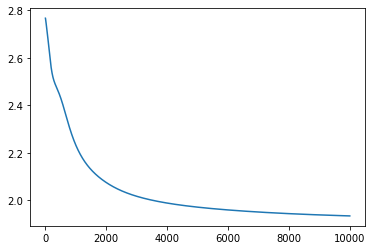

In [147]:
def train_net():
    def build_net():
        n1, n2, n3, n4 = 64, 32, 16, 10
        li1 = LinearLayer(n1, n2)
        li2 = LinearLayer(n2, n3, activation_func="sigmoid")
        li3 = LinearLayer(n3, n4, activation_func="sigmoid")
        net = NeuralNet([li1, li2])
        return net

    net = build_net()
    loss_func = CrossEntropyLossFromLogits()
    batch_size = 100
    alpha, lr = 0.7, 1e-3
    X, y = load_digits(return_X_y=True)
    xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2)
    
    net.reset_velocity()
    history = []
    for epoch in range(1, 10001):
        out  = net.forward(xtr)
        loss = loss_func.forward(out, ytr)
        
        delta = loss_func.backward()
#         print(out.shape, delta.shape)
        net.backward(delta)
        net.gradient_descent(alpha, lr)
        
        out = net.forward(xte)
        ypred = np.argmax(out, axis=1)
        acc = (ypred==yte).sum() / len(yte)
        
        history.append(loss)
        if epoch%500 == 0:
            print(epoch, loss, acc)
    return net, history
net, history = train_net()
plt.plot(history)